In [3]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 11.9 MB/s eta 0:00:00


In [4]:
import numpy as np ## importando as bibliotecas
import pandas as pd
import requests
import xlsxwriter
import math

In [ ]:
stocks = pd.read_csv("sp_500_stocks.csv")  ## csv com o ticker das 500 ações da S&P
stocks = stocks[~stocks['Ticker'].isin(['DISCA', 'HFC','VIAC','WLTW'])] 

In [ ]:
# como vou utilizar a API da IEX CLOUD, só é permitido 100 requests por bach, ou seja, preciso dividir o dataframe das empresas em sublistas de 100

def chuncks(lst, n): ## função para fazer subdivisões em listas
  for i in range(0, len(lst), n):
    yield lst[i:i+n]


symbol_groups = list(chuncks(stocks['Ticker'], 100))
symbol_strings= []
for i in range(0, len(symbol_groups)):
  symbol_strings.append(','.join(symbol_groups[i])) ## junta todos os tickers em uma lista.



O projeto se resume em fazer um estudo quantitativo de valor das ações da S&P 500 e escolher as 50 ações mais "subvalorizadas" .Usando 5 métricas:

1) Índice Preço/Lucro (Price–earnings ratio). Valor de mercado divido pelo lucro da empresa

2) Índice preço/conta (Price-to-book Ratio). Valor de Mercado da empresa divido por seu Patrimônio Líquido 

3) Relação preço/vendas(Price-to-sales Ratio). Valor de mercado divido pelo faturamento da empresa

4) EV/EBITDA. Valor de mercado dividio pelo lucro operacional(capacidade da empresa para pagar suas operações e gerar fluxo de caixa.)

5) EV/GP. Valor de Mercado divido pelo lucro bruto

Todos esses meios de cálculo de valor de uma empresa serão utilizados para o 
resultado final.


In [ ]:
#criando o dataframe



rv_columns= [ ## nome das colunas
    'Ticker',
    'Price',
    'Number of Shares to Buy',
    'Price-to-Earning Ratio',
    'PE Percentile',
    'Price-to-book Ratio',
    'PB Percentile',
    'Price-to-sales Ratio',
    'PS Percentile',
    'EV/EBITDA',
    'EV/EBITDA Percentile',
    'EV/GP',
    'EV/GP Percentile',
    'RV Score'
]

rv_dataframe = pd.DataFrame(columns = rv_columns) # criando um data frame

for symbol_string in symbol_strings: # percorre as 5 listas com 100 tickers
  batch_api = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbol_string}&types=quote,advanced-stats&token={IEX_CLOUD_API_TOKEN}' 
  data = requests.get(batch_api).json() #obtendo as estatisticas das 100 ações pelo api da IEX CLOUD
  for symbol in symbol_string.split(','): ## percore cada ticker
    enterprise_value = data[symbol]['advanced-stats']['enterpriseValue'] # obtendo valores
    ebitda =  data[symbol]['advanced-stats']['EBITDA']
    gross_profit = data[symbol]['advanced-stats']['grossProfit']

    try:
      ev_to_ebitda = enterprise_value/ebitda 
    except TypeError:
      ev_to_ebitda = np.NaN

# fazendo esses trys e excepts pois algumas empresas não divulgam tais informações. 
# o problema com os valores nulos sera resolvido mais a frente

    try:
      ev_to_gross_profit = enterprise_value/gross_profit
    except TypeError:
      ev_to_gross_profit = np.NaN


    rv_dataframe = rv_dataframe.append( ## adicionando as informações no dataframe
        pd.Series([
                symbol,
                data[symbol]['quote']['latestPrice'],
                'NaN', 
                data[symbol]['quote']['peRatio'],
                'N/A',
                data[symbol]['advanced-stats']['priceToBook'],
                'N/A',
                data[symbol]['advanced-stats']['priceToSales'],
                'N/A',
                ev_to_ebitda,
                'N/A',
                ev_to_gross_profit,
                'N/A',
                'N/A'
            

        ],
        index= rv_columns),
          ignore_index = True
    )


In [ ]:
rv_dataframe[rv_dataframe.isnull().any(axis=1)] # Lidando com valores NaN

In [ ]:
for column in ['Price-to-Earning Ratio',
                'Price-to-book Ratio',
            'Price-to-sales Ratio', 'EV/EBITDA',
            'EV/GP']:
  rv_dataframe[column].fillna(rv_dataframe[column].mean(), inplace=True) ## os valores que forem NaN vão receber a media das outras métricas

In [ ]:
rv_dataframe[rv_dataframe.isnull().any(axis=1)] # não existe mais valores Nan

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score


Calculando as Porcentagens


In [ ]:
from scipy.stats import percentileofscore as score

metricas = { ## dicionario 
    'Price-to-Earning Ratio':'PE Percentile',
    'Price-to-book Ratio':'PB Percentile',
    'Price-to-sales Ratio':'PS Percentile',
    'EV/EBITDA':'EV/EBITDA Percentile',
    'EV/GP':'EV/GP Percentile',

}
for metric in metricas.keys(): ## percore pelas chaves do dicionario(price-to-earning  etc .. ) 
  for row in rv_dataframe.index: ## percore todas as linhas do data frame 
    rv_dataframe.loc[row, metricas[metric]] = score(rv_dataframe[metric], rv_dataframe.loc[row, metric])
## para cada linha, entra na coluna dos percentiles e calcula o score
## score = porcentagem em comparação aos outros, ex: se o numero for maior que 80%
## dos outros valores da coluna, então recebe 80%



Calculando o rv score

In [ ]:
from statistics import mean

for row in rv_dataframe.index: ## percorre todas as linhas do tada frame
  value_percentiles = [] ## lista para pegar todas as procentagens da linha
  for metric in metricas.keys():
    value_percentiles.append(rv_dataframe.loc[row, metricas[metric]]) ## adicionando todas as porcentagens na lista
  
  
  rv_dataframe.loc[row, 'RV Score'] = mean(value_percentiles) ## rv score da linha = media das porcentagens

Selecionando as 50 melhores ações

In [ ]:
rv_dataframe.sort_values('RV Score', ascending=True, inplace=True) # ordenando o data frame pelo RV Score

In [ ]:
rv_dataframe = rv_dataframe[(rv_dataframe['Price-to-Earning Ratio']>0) & (rv_dataframe['Price-to-book Ratio']>0) & (rv_dataframe['EV/EBITDA'] > 0) & (rv_dataframe['EV/GP'] > 0)]
#removendo valores negativos.
#removo esses valores pois evidenciam que a empresa não esta indo bem.
#A exemplo, se a price-to-earning for negativa, quer dizer que a empresa está com prejuízo.

In [ ]:
rv_dataframe = rv_dataframe[:50] # pegando as 50 ações com menor score

In [ ]:
rv_dataframe.reset_index(drop=True, inplace=True)

Numero de ações para comprar 

In [ ]:
def portfolio_input():
  global portfolio_size
  portfolio_size = input('Digite o vlaor do Investimento: ')

  try:
    val = float(portfolio_size)

  except ValueError:
    print('Digite em formato de numeral!')
    portfolio_size = float(input("Digite o valor de Investimento: "))

#função para receber o valor a ser investido    

In [ ]:
portfolio_input() # para o exemplo vou usar 1.000.000

Digite o vlaor do Investimento: 100000000


In [ ]:
position_size = float(portfolio_size)/len(rv_dataframe.index)
position_size

2000000.0

In [ ]:
for row in rv_dataframe.index: ## calculando a quantidade de funções para comprar de cada empresa e colocando no dataframe
  rv_dataframe.loc[row, 'Number of Shares to Buy'] = math.floor(position_size/rv_dataframe.loc[row, 'Price'])

In [ ]:
rv_dataframe # dataframe final

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,FRC,13.12,152439,1.59,8.582834,0.1770,6.586826,0.3621,4.99002,1.048004,2.195609,0.367889,0.399202,4.550898
1,GM,34.49,57987,5.63,12.37525,0.7104,8.582834,0.3072,3.592814,1.546249,2.39521,1.162679,6.387226,6.666667
2,AIG,51.44,38880,3.96,9.381238,0.9584,10.578842,0.6710,10.379242,1.958826,2.59481,0.671048,2.39521,7.065868
3,UNM,40.03,49962,6.16,13.373253,0.8565,9.381238,0.6570,9.780439,3.544797,4.99002,0.656989,2.195609,7.944112
4,SYF,29.80,67114,4.85,10.978044,1.0500,12.57485,0.6791,10.578842,2.911408,3.592814,0.827809,3.592814,8.263473
5,C,49.56,40355,7.11,14.770459,0.5046,7.185629,0.9051,15.169661,3.985331,6.187625,0.953393,4.191617,9.500998
6,COF,96.58,20708,5.39,11.976048,0.6952,8.383234,0.9526,16.167665,3.929849,5.988024,1.124851,5.988024,9.700599
7,ZION,29.95,66777,3.09,8.982036,1.0400,12.075848,1.1700,20.858283,2.500426,2.994012,1.205143,7.185629,10.419162
8,DISH,7.84,255102,2.17,8.782435,0.1361,6.387226,0.1464,0.798403,7.655204,19.560878,3.987949,27.944112,12.694611
9,PFG,75.89,26353,4.03,9.580838,1.8200,27.844311,1.0400,17.764471,2.869806,3.393214,1.042814,4.99002,12.714571


Transformando esses dados em um excel para futuras pesquisas


In [ ]:
writer = pd.ExcelWriter('value_strategy.xlsx', engine='xlsxwriter')
rv_dataframe.to_excel(writer, sheet_name ='Compras', index=False)
writer.save()

<ipython-input-204-ec70628d3535>:3: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Estudo de algumas das empresas melhores colocadas para os investimentos: 

A empresa melhor colocada, First Republic Bank, é uma empresa bancária da Califórnia, quais ações cairam 90% nos ultimos 6 meses


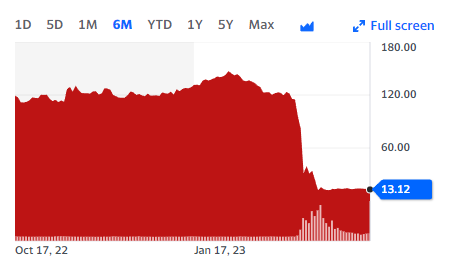

Fazendo um estudo do top 10, percebe-se que 8 empresas são do ramo financeiro, bancário ou de seguros. Isso devido ao cenário atual da economia americana, em que vários bancos estão quebrando e portanto, está ocorrendo a desvalorização de muitos deles, a exemplo de um banco que quebrou, o Silicon Valley Bank

Além disso, percebe-se que 9 de todas as ações no top 10 estão em queda nos ultimos 6 meses, evidenciando que os modelos matemáticos utilizados para fazer o estudo quantitativo "procuram" empresas subvalorizadas. Exemplos:


Synchrony Financial (SYF): 




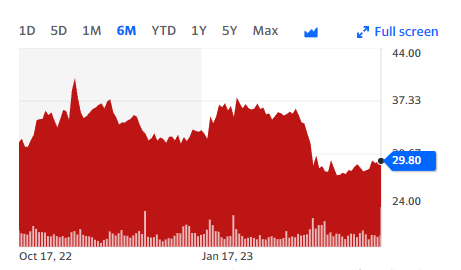




Principal Financial Group, Inc. (PFG):



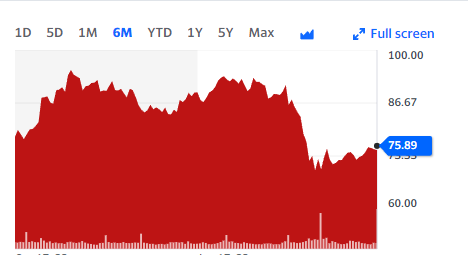

Perceb-se que todas possuem uma grande queda nos dias 10-12 de março de 2023. Sendo o dia 10, o dia em que o Silicon Valley Bank colapsou

Estudo feito no dia 15/04


Estudo continuará após um mês para verificar os ganhos ou perdas nas ações nessa situação hipotética de investimento

Dia 18/04, mudanças na porcentagem de cada ação após 3 dias



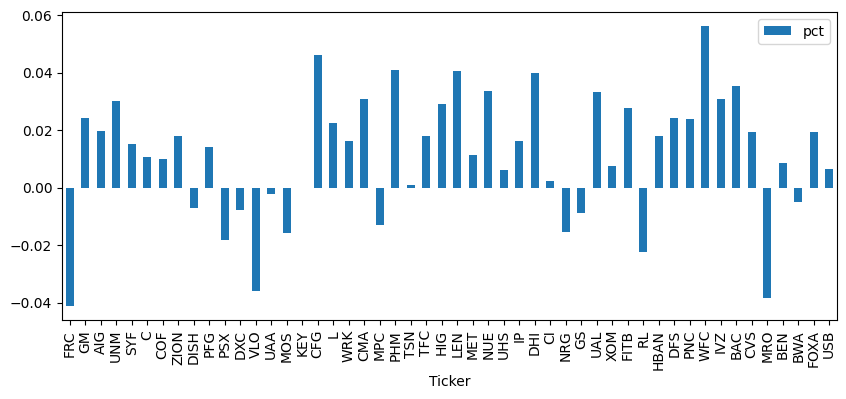

[1917682.62, 2048680.71, 2039644.8, 2059933.2599999998, 2030198.5, 2020978.4, 2020065.4, 2036030.73, 1985969.07, 2028258.645, 1963218.51, 1984324.72, 1927877.3699999999, 1995639.59, 1968066.8800000001, 1999988.25, 2092080.32, 2045113.1099999999, 2032470.2300000002, 2061876.96, 1973585.52, 2081430.4500000002, 2001588.21, 2036077.5, 2057873.9400000002, 2080884.75, 2022739.52, 2066774.4000000001, 2012054.4000000001, 2032274.06, 2079976.08, 2004547.1099999999, 1968757.3199999998, 1982089.7600000002, 2066227.7999999998, 2015227.02, 2055193.1400000001, 1954748.16, 2035923.6600000001, 2048557.8399999999, 2047685.8800000001, 2112508.98, 2061570.33, 2070440.0, 2038496.22, 1923040.2, 2017186.68, 1989716.16, 2038899.7200000002, 2012551.2899999998] --- total 
101146724.175

In [ ]:
##### codigo extra para análise

In [ ]:
#dia 18/04
stocks_escolhidas = pd.read_excel('value_strategy.xlsx') ## pegando os tickers escolhidos pelo estudo qualitativo

amount_each_stock = []

for row in stocks_escolhidas.index:
  amount_each_stock.append(stocks_escolhidas.loc[row, 'Number of Shares to Buy'] * stocks_escolhidas.loc[row, 'Price'])


tickers = stocks_escolhidas['Ticker']
tickers = tickers.tolist()

ticker_string = ','.join(tickers)

In [ ]:
IEX_CLOUD_API_TOKEN = '#####'

rv_columns= [ ## nome das colunas
    'Ticker',
    'Price',
    'Number of Shares to Buy',
    'Price-to-Earning Ratio',
    'PE Percentile',
    'Price-to-book Ratio',
    'PB Percentile',
    'Price-to-sales Ratio',
    'PS Percentile',
    'EV/EBITDA',
    'EV/EBITDA Percentile',
    'EV/GP',
    'EV/GP Percentile',
    'RV Score'
]

analysis_df = pd.DataFrame(columns = rv_columns)

In [ ]:
batch_api = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={ticker_string}&types=quote,advanced-stats&token={IEX_CLOUD_API_TOKEN}' 
data = requests.get(batch_api).json() #obtendo as estatisticas das 100 ações pelo api da IEX CLOUD
print(data.keys())


In [ ]:
  for ticker in tickers: ## percore cada ticker
    enterprise_value = data[ticker]['advanced-stats']['enterpriseValue'] # obtendo valores
    ebitda =  data[ticker]['advanced-stats']['EBITDA']
    gross_profit = data[ticker]['advanced-stats']['grossProfit']

    try:
      ev_to_ebitda = enterprise_value/ebitda 
    except TypeError:
      ev_to_ebitda = np.NaN

# fazendo esses trys e excepts pois algumas empresas não divulgam tais informações. 
# o problema com os valores nulos sera resolvido mais a frente

    try:
      ev_to_gross_profit = enterprise_value/gross_profit
    except TypeError:
      ev_to_gross_profit = np.NaN


    analysis_df = analysis_df.append( ## adicionando as informações no dataframe
        pd.Series([
                ticker,
                data[ticker]['quote']['latestPrice'],
                'NaN', 
                data[ticker]['quote']['peRatio'],
                'N/A',
                data[ticker]['advanced-stats']['priceToBook'],
                'N/A',
                data[ticker]['advanced-stats']['priceToSales'],
                'N/A',
                ev_to_ebitda,
                'N/A',
                ev_to_gross_profit,
                'N/A',
                'N/A'
            

        ],
        index= rv_columns),
          ignore_index = True
    )


In [74]:
for column in ['Price-to-Earning Ratio',
                'Price-to-book Ratio',
            'Price-to-sales Ratio', 'EV/EBITDA',
            'EV/GP']:
  analysis_df[column].fillna(analysis_df[column].mean(), inplace=True) ## os valores que forem NaN vão receber a media das outras métricas

In [75]:
from scipy.stats import percentileofscore as score

metricas = { ## dicionario 
    'Price-to-Earning Ratio':'PE Percentile',
    'Price-to-book Ratio':'PB Percentile',
    'Price-to-sales Ratio':'PS Percentile',
    'EV/EBITDA':'EV/EBITDA Percentile',
    'EV/GP':'EV/GP Percentile',

}
for metric in metricas.keys(): ## percore pelas chaves do dicionario(price-to-earning  etc .. ) 
  for row in analysis_df.index: ## percore todas as linhas do data frame 
    analysis_df.loc[row, metricas[metric]] = score(analysis_df[metric], analysis_df.loc[row, metric])
## para cada linha, entra na coluna dos percentiles e calcula o score
## score = porcentagem em comparação aos outros, ex: se o numero for maior que 80%
## dos outros valores da coluna, então recebe 80%



In [77]:
from statistics import mean

for row in analysis_df.index: ## percorre todas as linhas do tada frame
  value_percentiles = [] ## lista para pegar todas as procentagens da linha
  for metric in metricas.keys():
    value_percentiles.append(analysis_df.loc[row, metricas[metric]]) ## adicionando todas as porcentagens na lista
  
  
  analysis_df.loc[row, 'RV Score'] = mean(value_percentiles) ## rv score da linha = media das porcentagens

In [ ]:
analysis_df['Number of Shares to Buy'] = stocks_escolhidas['Number of Shares to Buy']

In [129]:
total = 0
stocks_total_analysis = []


for row in analysis_df.index:
  stocks_total_analysis.append(analysis_df.loc[row, 'Number of Shares to Buy'] * analysis_df.loc[row, 'Price'])


total = sum(stocks_total_analysis)
print(total)



101146724.175


In [124]:
print(stocks_total_analysis)

[1917682.62, 2048680.71, 2039644.8, 2059933.2599999998, 2030198.5, 2020978.4, 2020065.4, 2036030.73, 1985969.07, 2028258.645, 1963218.51, 1984324.72, 1927877.3699999999, 1995639.59, 1968066.8800000001, 1999988.25, 2092080.32, 2045113.1099999999, 2032470.2300000002, 2061876.96, 1973585.52, 2081430.4500000002, 2001588.21, 2036077.5, 2057873.9400000002, 2080884.75, 2022739.52, 2066774.4000000001, 2012054.4000000001, 2032274.06, 2079976.08, 2004547.1099999999, 1968757.3199999998, 1982089.7600000002, 2066227.7999999998, 2015227.02, 2055193.1400000001, 1954748.16, 2035923.6600000001, 2048557.8399999999, 2047685.8800000001, 2112508.98, 2061570.33, 2070440.0, 2038496.22, 1923040.2, 2017186.68, 1989716.16, 2038899.7200000002, 2012551.2899999998]


In [96]:
import matplotlib.pyplot as plt

In [ ]:
pct_changes = []

for i in range(len(stocks_total_analysis)):
  pct_changes.append(stocks_total_analysis[i] / amount_each_stock[i]- 1)


test = pd.DataFrame()
test['Ticker'] = tickers
test['pct'] = pct_changes

test

<Axes: xlabel='Ticker'>

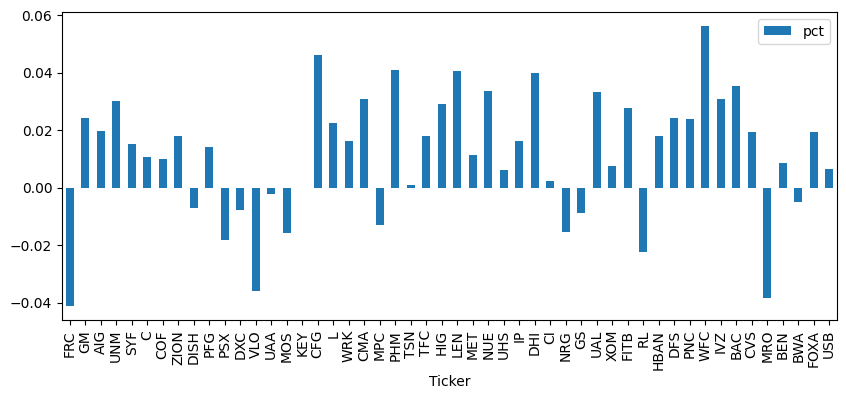

In [123]:
test.plot.bar(x='Ticker',
              figsize=(10,4))